In [1]:
import sys
sys.path.append('../../')
# Core Libs
import copy
# External Libs
import numpy as np
from scipy.stats import multinomial
import arviz as az
import pymc as pm
import pytensor
from pytensor.compile.debugmode import DebugMode
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import json
import pandas as pd
import time

In [2]:
data = np.array([ #N,M,DEM,DEMZ,S
    #Beta Uninformed
    [1, 0, 0, 0, 0],  # NUTS Preferred
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0],
    [1, 0, 1, 1, 1],
    [0, 0, 0, 1, 0],
    
    #Alpha Uninformed
    [0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 1, 1, 1],
    
    #Beta Informed
    [1, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0],
    
    #Alpha Informed
    [1, 0, 0, 0, 1], 
    [0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1], 
    [1, 0, 0, 0, 1], 
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [1, 0, 0, 0, 1], 
    [0, 1, 0, 1, 0]
])

n_algs = data.shape[1]  # Number of Algorithms

n_metrics = data.shape[0]

In [3]:
with pm.Model() as model:
    strengths = pm.Normal("strengths", mu=0, sigma=1, shape=n_algs)
    
    # Calculate the pairwise differences in strengths
    diff_strengths = strengths - strengths.T
    
    # Apply a logistic transformation to obtain probabilities
    #p = pm.Deterministic("p", pm.math.sigmoid(diff_strengths))
    logits = pm.Deterministic("logits", strengths - strengths.mean())
    probability = pm.Deterministic("p", pm.math.softmax(logits)) #makes it add up to 1
    
    # Step 2: Define the likelihood
    # Reshape the data for broadcasting
    reshaped_data = data.reshape(n_metrics, 1, n_algs)
    
    # Likelihood function using the observed data
    obs = pm.Bernoulli("obs", p=probability, observed=reshaped_data)

In [4]:
# Step 4: Inference
with model:
    idata = pm.sample(draws=4000,tune=4000, cores=32,step=pm.Slice())


Multiprocess sampling (32 chains in 32 jobs)
Slice: [strengths]


Sampling 32 chains for 4_000 tune and 4_000 draw iterations (128_000 + 128_000 draws total) took 20 seconds.


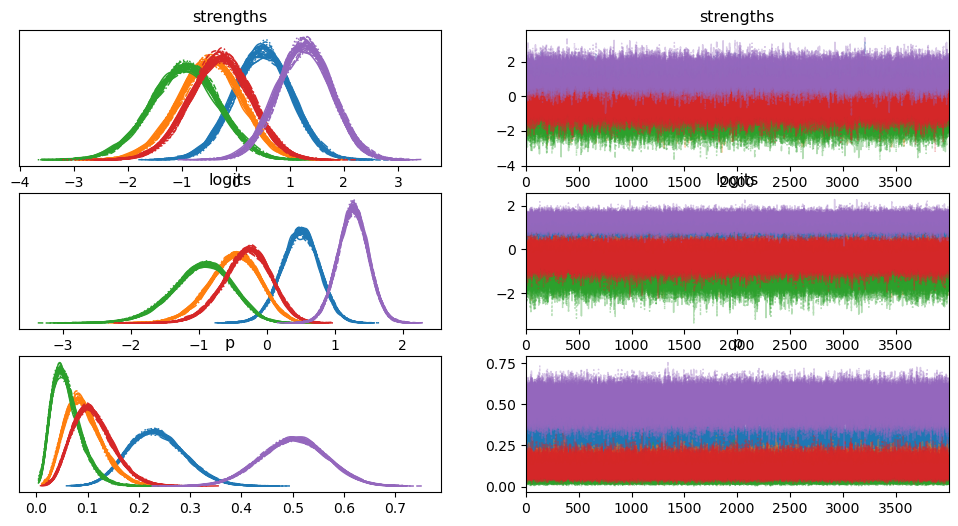

In [5]:
az.plot_trace(idata)
plt.show()

In [6]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
strengths[0],0.489,0.528,-0.520,1.465,0.004,0.003,18055.0,36721.0,1.0
strengths[1],-0.485,0.585,-1.586,0.615,0.004,0.003,25162.0,49112.0,1.0
strengths[2],-0.962,0.626,-2.143,0.212,0.003,0.002,32846.0,58360.0,1.0
strengths[3],-0.297,0.570,-1.382,0.766,0.004,0.003,23544.0,46444.0,1.0
strengths[4],1.269,0.503,0.321,2.212,0.004,0.003,16328.0,32767.0,1.0
logits[0],0.487,0.277,-0.036,1.000,0.001,0.001,128743.0,113726.0,1.0
logits[1],-0.488,0.374,-1.200,0.199,0.001,0.001,130855.0,100803.0,1.0
logits[2],-0.965,0.437,-1.780,-0.150,0.001,0.001,114406.0,95166.0,1.0
logits[3],-0.300,0.351,-0.974,0.342,0.001,0.001,136199.0,102721.0,1.0
logits[4],1.266,0.224,0.844,1.688,0.001,0.000,131543.0,117604.0,1.0


In [7]:
az.summary(idata,var_names=["p"],kind="stats")

,mean,sd,hdi_3%,hdi_97%
p[0],0.234,0.055,0.134,0.337
p[1],0.093,0.037,0.031,0.162
p[2],0.060,0.029,0.013,0.113
p[3],0.111,0.040,0.041,0.185
p[4],0.501,0.064,0.381,0.620


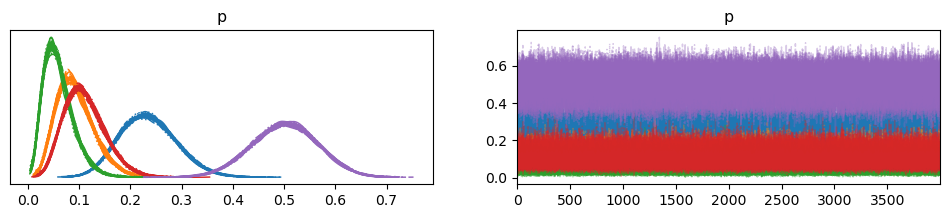

In [8]:
az.plot_trace(idata, var_names=["p"])
plt.show()